# Nested Summarization With Heading Hierarchy: Semantic Processing
### AI 829: NLP Mandate 4 Contribution
By: Rachna S Kedigehalli (IMT2019069)
    Nandakishore S Menon (IMT2019057)

## Abstract
Through this mandate, we have finished implementing the NLP application proposed in our first mandate. Given an article/paragraph, the sentences are classified into topics and titles, subtitles and summaries are generated appropriately. Semantic analysis (aboutness) is used to determine keywords/title for each subtopic.

For the title generation task, we have also experimented with RNNs based on https://arxiv.org/pdf/1512.01712.pdf by referring to https://github.com/NainiShah/News-Headline-Generation. However, we abandoned the approach since we could not train the model over sufficient iterations due to memory constraints. The code is present in the other notebook titled "title_generation_experiment". 

In [1]:
import numpy as np
import pandas as pd

In [2]:
# document = input()

In [3]:
document = "Health was earlier said to be the ability of the body functioning well. However, as time evolved, the definition of health also evolved. It cannot be stressed enough that health is the primary thing after which everything else follows. When you maintain good health, everything else falls into place.Similarly, maintaining good health is dependent on a lot of factors. It ranges from the air you breathe to the type of people you choose to spend your time with. Health has a lot of components that carry equal importance. If even one of them is missing, a person cannot be completely healthy. First, we have our physical health. This means being fit physically and in the absence of any kind of disease or illness. When you have good physical health, you will have a longer life span. One may maintain their physical health by having a balanced diet. Do not miss out on the essential nutrients; take each of them in appropriate quantities. Junk foods taste good that’s why it is mostly liked by everyone of any age group especially kids and school going children. They generally ask for the junk food daily because they have been trend so by their parents from the childhood. They never have been discussed by their parents about the harmful effects of junk foods over health. According to the research by scientists, it has been found that junk foods have negative effects on the health in many ways. They are generally fried food found in the market in the packets. They become high in calories, high in cholesterol, low in healthy nutrients, high in sodium mineral, high in sugar, starch, unhealthy fat, lack of protein and lack of dietary fibers. Processed and junk foods are the means of rapid and unhealthy weight gain and negatively impact the whole body throughout the life. It makes able a person to gain excessive weight which is called as obesity. Junk foods tastes good and looks good however do not fulfil the healthy calorie requirement of the body. Some of the foods like french fries, fried foods, pizza, burgers, candy, soft drinks, baked goods, ice cream, cookies, etc are the example of high-sugar and high-fat containing foods. It is found according to the Centres for Disease Control and Prevention that Kids and children eating junk food are more prone to the type-2 diabetes. "

# Pre-processing

## Expanding Contractions
Eg: he's -> he is

In [4]:
!pip install contractions
import contractions
from nltk.tokenize import word_tokenize
import re

In [5]:
def expand_contractions(sentence):
    contractions_expanded = [contractions.fix(word) for word in sentence.split()]
    return ' '.join(contractions_expanded) 

In [6]:
document = expand_contractions(document)

Convert the document into a vector of tokenized sentences.

In [7]:
def split_into_sentences(doc):
    return [x for x in doc.split('.') if x != '']

In [8]:
def remove_punctuation(tokens):
    return [re.sub(r'[^\w\s]', '', word) for word in tokens]
def lower_case(tokens):
    return [word.lower() for word in tokens if word != '']

In [9]:
def sentences_to_vectors(doc):
# doc is a list of sentences
# tokenize every sentence, convert to lower case and remove punctuation
    vectors = [word_tokenize(sentence) for sentence in doc]
    for i in range(len(vectors)):
        vectors[i] = lower_case(remove_punctuation(vectors[i]))
    return vectors

In [10]:
sentences = split_into_sentences(document)
sentence_vectors = sentences_to_vectors(sentences)
preprocessed_sentences = [" ".join(sentence) for sentence in sentence_vectors]

# Sentence Clustering
Since this is an unsupervised task, we use hierarchical agglomerative clustering.\
Tf-Idf is used to obtain vectors corresponding to the sentences.\
The optimal number of clusters is found using ```hierarchy.linkage()``` which gives the clusters at every iteration of the hierarchical clustering.

## Tf-idf

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [12]:
tfidf = TfidfVectorizer(analyzer='word', min_df=0)

In [13]:
tfidf_wm = tfidf.fit_transform(preprocessed_sentences)
tfidf_tokens = tfidf.get_feature_names()
X = pd.DataFrame(data = tfidf_wm.toarray(),columns = tfidf_tokens)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Hierarchical Clustering

In [14]:
from scipy.cluster import hierarchy
from sklearn.cluster import AgglomerativeClustering

In [15]:
Z = hierarchy.linkage(X, 'ward')

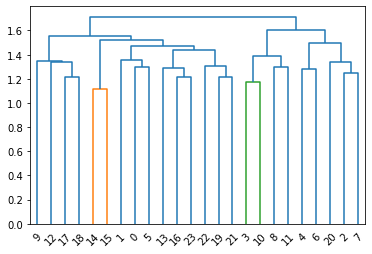

In [16]:
dend = hierarchy.dendrogram(Z)

This will be used to find the number of clusters.

In [17]:
def find_num_clusters(Z):
    # sort by distance
    Z = Z[Z[:, 2].argsort()]
    max_diff = 0
    max_index = 0
    for i in range(len(Z)-1):
        if Z[i+1][2]-Z[i][2] > max_diff:
            max_diff = Z[i+1][2]-Z[i][2]
            max_index = i
    return len(Z)-max_index

In [18]:
num_clusters = find_num_clusters(Z)

In [19]:
hc = AgglomerativeClustering(n_clusters=num_clusters, affinity='euclidean', linkage='ward')

In [20]:
y_hc = hc.fit_predict(X)

In [21]:
y_hc

array([1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1])

In [22]:
clustered_sentences = [[] for i in range(num_clusters)]

In [23]:
for i, sentence in enumerate(preprocessed_sentences):
    cluster_id = y_hc[i]
    clustered_sentences[cluster_id].append(sentences[i])

In [24]:
clustered_sentences

[[' It cannot be stressed enough that health is the primary thing after which everything else follows',
  ' When you maintain good health, everything else falls into place',
  'Similarly, maintaining good health is dependent on a lot of factors',
  ' Health has a lot of components that carry equal importance',
  ' If even one of them is missing, a person cannot be completely healthy',
  ' First, we have our physical health',
  ' When you have good physical health, you will have a longer life span',
  ' One may maintain their physical health by having a balanced diet',
  ' It makes able a person to gain excessive weight which is called as obesity'],
 ['Health was earlier said to be the ability of the body functioning well',
  ' However, as time evolved, the definition of health also evolved',
  ' It ranges from the air you breathe to the type of people you choose to spend your time with',
  ' This means being fit physically and in the absence of any kind of disease or illness',
  ' Do n

# Title Generation/ Topic Modeling

In [25]:
import nltk
from nltk.corpus import stopwords
import gensim
from gensim import corpora

In [26]:
stopwords = set(stopwords.words('english'))
def remove_stopwords(tokens):
    return [word for word in tokens if word not in stopwords and word]

In [27]:
def clean_for_topic_modeling(docs):
#     input is list of sentences split (remove punctuation, expanded contractions)
#     remove stopwords
    return [remove_stopwords(doc) for doc in docs]

In [28]:
def get_topics(sentence_tokens, num_topics=1, num_words=2):
    dictionary = corpora.Dictionary(sentence_tokens)
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in sentence_tokens]
    Lda = gensim.models.ldamodel.LdaModel
    ldamodel = Lda(doc_term_matrix, num_topics, id2word=dictionary, passes=30)
    return ldamodel.print_topics(num_topics, num_words)

In [29]:
def topic_for_para(doc, num_topics=1, num_words=2):
    sentences = split_into_sentences(doc)
    sentence_vectors = sentences_to_vectors(sentences)
    sentence_tokens = clean_for_topic_modeling(sentence_vectors)
    return get_topics(sentence_tokens, num_topics, num_words)

In [30]:
topic_for_para(document, num_topics=1, num_words=3)

[(0, '0.031*"health" + 0.024*"foods" + 0.021*"junk"')]

# Loading data for training model for summarization and title generation

In [31]:
from os import listdir
from string import punctuation
punctuation+='\n'
import re
from bs4 import BeautifulSoup
import pandas as pd
import math
from tqdm import tqdm

In [32]:
def load_doc(filename):
    file = open(filename, encoding='utf-8')
    text = file.read()
    file.close()
    return text

In [33]:
def split_story(doc):
    index = doc.find('@highlight')
    story, highlights = doc[:index], doc[index:].split('@highlight')
    highlights = [h.strip() for h in highlights if len(h) > 0]
    return story, highlights

In [34]:
def load_stories(directory):
    all_stories = list()
    for name in tqdm(listdir(directory)):
        filename = directory + '/' + name
        doc = load_doc(filename)
        story, highlights = split_story(doc)
        all_stories.append({'story':story, 'highlights':highlights})
    return all_stories

In [35]:
directory = '../input/cnn-dailymail/cnn/stories'
data = load_stories(directory)
print('Loaded Stories %d' % len(data))

100%|██████████| 92579/92579 [06:15<00:00, 246.67it/s]

Loaded Stories 92579


In [36]:
stories = [story['story'] for story in data]

In [37]:
data_df = [[d['story'], d['highlights']] for d in data]

In [38]:
df = pd.DataFrame(data_df).rename(columns={0:"text", 1:"summary"})
df.head()

,text,summary
0,Washington (CNN) -- After years of planning an...,[Romney and running mate Paul Ryan to campaign...
1,In its effort to curb game addiction among ado...,"[The ""Cinderella law"" blocks under-16 gamers f..."
2,"(CNN)On the surface, the mix-up seems incompre...",[Attorney: Robert Bates assumed the gun was a ...
3,"(CNN) -- Since appearing on season 13 of ""Danc...",[Chaz Bono says a change in eating habits help...
4,(CNN) -- The late Chris Benoit idolized the Dy...,[Vince McMahon: WWE has one of best drug-testi...


### Pre-process data

In [39]:
df['text'] = df['text'].apply(lambda x: x.replace('\n',''))
df['text'] = df['text'].apply(lambda x: x.replace("\"", ""))
df['summary'] = df['summary'].apply(lambda x: ". ".join(x))
df.head()

,text,summary
0,Washington (CNN) -- After years of planning an...,Romney and running mate Paul Ryan to campaign ...
1,In its effort to curb game addiction among ado...,"The ""Cinderella law"" blocks under-16 gamers fr..."
2,"(CNN)On the surface, the mix-up seems incompre...",Attorney: Robert Bates assumed the gun was a T...
3,(CNN) -- Since appearing on season 13 of Danci...,Chaz Bono says a change in eating habits helpe...
4,(CNN) -- The late Chris Benoit idolized the Dy...,Vince McMahon: WWE has one of best drug-testin...


## Train-test split

In [40]:
train_size = math.floor(0.9999*len(df))
train_df = df[:train_size]
test_df = df[train_size:].copy()

# Summarization
We use the pre-trained BART model and fine-tuned it for our dataset (CNN-Dailymail).

## Fine-tuning BART
BART uses a standard Transformer-based neural machine translation architecture. It uses a standard seq2seq/machine translation architecture with a bidirectional encoder (like BERT) and a left-to-right decoder (like GPT). Here, BART is trained over the cnn-dailymail dataset.

In [41]:
!pip install ohmeow-blurr -q
!pip install bert-score -q
!pip install blurr

In [42]:
from fastai.text.all import *
from transformers import *
from blurr.text.data.all import *
from blurr.text.modeling.all import *

from tqdm import tqdm

In [43]:
pretrained_model_name = "facebook/bart-large-cnn"
hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(pretrained_model_name, 
                                                                  model_cls=BartForConditionalGeneration)
hf_arch, type(hf_config), type(hf_tokenizer), type(hf_model)

('bart',
 transformers.models.bart.configuration_bart.BartConfig,
 transformers.models.bart.tokenization_bart_fast.BartTokenizerFast,
 transformers.models.bart.modeling_bart.BartForConditionalGeneration)

In [44]:
hf_batch_tfm = Seq2SeqBatchTokenizeTransform(hf_arch, hf_config, hf_tokenizer, hf_model,is_split_into_words=True, task='summarization',
text_gen_kwargs={'max_length': 248,
 'min_length': 56,
 'do_sample': False,
 'early_stopping': True,
 'num_beams': 4,
 'temperature': 1.0,
 'top_k': 50,
 'top_p': 1.0,
 'repetition_penalty': 1.0,
 'bad_words_ids': None,
 'bos_token_id': 0,
 'pad_token_id': 1,
 'eos_token_id': 2,
 'length_penalty': 2.0,
 'no_repeat_ngram_size': 3,
 'encoder_no_repeat_ngram_size': 0,
 'num_return_sequences': 1,
 'decoder_start_token_id': 2,
 'use_cache': True,
 'num_beam_groups': 1,
 'diversity_penalty': 0.0,
 'output_attentions': False,
 'output_hidden_states': False,
 'output_scores': False,
 'return_dict_in_generate': False,
 'forced_bos_token_id': 0,
 'forced_eos_token_id': 2,
 'remove_invalid_values': False})

In [45]:
blocks = (Seq2SeqTextBlock(hf_arch, hf_config, hf_tokenizer, hf_model, task='summarization'), noop)

dblock = DataBlock(blocks=blocks, get_x=ColReader('text'), get_y=ColReader('summary'), splitter=RandomSplitter())

In [46]:
seq2seq_metrics = {
        'rouge': {
            'compute_kwargs': { 'rouge_types': ["rouge1", "rouge2", "rougeL"], 'use_stemmer': True },
            'returns': ["rouge1", "rouge2", "rougeL"]
        },
        'bertscore': {
            'compute_kwargs': { 'lang': 'fr' },
            'returns': ["precision", "recall", "f1"]
        }
    }

In [47]:
dls = dblock.dataloaders(train_df, bs=2)

In [48]:
model = BaseModelWrapper(hf_model)
learn_cbs = [BaseModelCallback]
fit_cbs = [Seq2SeqMetricsCallback(custom_metrics=seq2seq_metrics)]

learn = Learner(dls, 
                model,
                opt_func=ranger,
                loss_func=CrossEntropyLossFlat(),
                cbs=learn_cbs,
                splitter=partial(blurr_seq2seq_splitter, arch=hf_arch)).to_fp16()

learn.create_opt() 
learn.freeze()

In [49]:
def summarize_doc(doc):
    return learn.blurr_generate(doc, early_stopping=False, num_return_sequences=1)[0]['generated_texts']

In [50]:
def summarize(data):
#     Takes a pd data series as input
    tqdm.pandas(desc='Summarization')
    return data.progress_apply(lambda x: summarize_doc(x))

In [51]:
test_df['generated_summary'] = summarize(test_df['text'])

Summarization: 100%|██████████| 10/10 [02:24<00:00, 14.46s/it]


In [52]:
test_df.head()

,text,summary,generated_summary
92569,"London, England (CNN) -- Artwork that used to adorn the walls and halls of Lehman Brothers' offices in London is expected to fetch two million pounds ($3.1 million) when it goes up for auction Wednesday.Christie's auction house in London is selling the art, which includes works by Lucian Freud and Anthony Gormley, antique maps and surveys, Chinese ceramics, and even Lehman Brothers signs.Lehman Brothers filed for bankruptcy in the United States two years ago following a nearly $4 billion loss, the failure of buyout negotiations with Bank of America and Barclays Capital, and the refusal of ...",The art and signage used to be at their offices in London. Lehman Brothers collapsed two years ago. The sale will help to pay off creditors,"Christie's auction house in London is selling the art, which includes works by Lucian Freud and Anthony Gormley. Lehman Brothers filed for bankruptcy in the United States two years ago following a nearly $4 billion loss. The auction date was chosen to coincide with the second anniversary of the Lehman collapse. The art will be up for public viewings starting this weekend."
92570,"(CNN) -- If it seems to you that there's a food safety crisis every other week, you're actually not paying close enough attention. Since the start of summer 2014 alone, the Food and Drug Administration has announced 37 different recalls, market alerts and safety withdrawals related to food, and the Food Safety and Inspection Service has issued 14.Some recalls result from mislabeling (such as undeclared ingredients like shellfish, milk, nuts, eggs or wheat gluten) or improper processing, while other recalled foods were contaminated with listeria, E. coli, salmonella or botulism.About 48 mil...","1 in 6 Americans will get food poisoning this year. According to the federal government, these illnesses are largely preventable. Recalls by federal agencies can help keep the public safe. Social media and newsfeeds can help you stay on top of food safety news","Since the start of summer 2014, the FDA has announced 37 different recalls, market alerts and safety withdrawals. About 48 million people -- 1 in 6 Americans -- contract some form of food poisoning each year. It's in a food producer's best interest to get a bad product off store shelves and alert consumers as swiftly as possible."
92571,(CNN) -- Serena Williams has handed a three-year suspended ban from the U.S. Open after her verbal tirade at a lineswoman at this year's event.The incident occurred during her semifinal defeat to Kim Clijsters when Williams was called for a foot fault to give the Belgian mum match point and her profanity-laced tirade resulted in a penalty point that ended the match.The punishments handed down by the International Tennis Federation's Grand Slam committee could result in a U.S. Open suspension if Williams commits another major violation in any Grand Slam event in 2010 or 2011.Williams was fi...,"Serena Williams is handed a three-year suspended ban from the U.S. Open. The punishment follows her outburst in the U.S. Open semifinal against Kim Clijsters. Williams also fined a record $175,000 with the amount to be reduced to $82,500 for good behavior","Serena Williams handed a three-year suspended ban from the U.S. Open after her verbal tirade at a lineswoman. The incident occurred during her semifinal defeat to Kim Clijsters. Williams was fined a record $175,000 with the amount to be reduced to $82,500 if she stays on good behavior over two seasons. Williams initially declined to issue an apology to the line-judge but subsequently issued a contrite statement."
92572,"LOS ANGELES, California (CNN) -- The nude body of a former swimsuit model found last weekend in Orange County was identified through her breast implants' serial number, two law enforcement sources said Friday.An arrest warrant has been issued for Ryan Alexander Jenkins, wanted in the death of Jasmine Fiore.An arrest warrant alleging murder was iss

# Score

## ROUGE Score

In [53]:
from rouge_score import rouge_scorer

In [54]:
def rouge_score(ground_truth, predicted, rouge_scores, score_type=['rougeL']):
    scorer = rouge_scorer.RougeScorer(score_type, use_stemmer=True)
    for i in range(len(ground_truth)):
        scores = scorer.score(ground_truth.iloc[i], predicted.iloc[i])
        rouge_scores.iloc[i] = scores['rougeL'].fmeasure
    return rouge_scores.min(), rouge_scores.max(), rouge_scores.mean(), rouge_scores.median()

In [55]:
test_df['rouge_score'] = ''
rouge_min, rouge_max, rouge_mean, rouge_median = rouge_score(test_df['summary'], test_df['generated_summary'], test_df['rouge_score'])

In [56]:
print("Rouge score:")
print("Minimum: ", rouge_min)
print("Maximum: ", rouge_max)
print("Mean: ", rouge_mean)
print("Median: ", rouge_median)

Rouge score:
Minimum:  0.17647058823529413
Maximum:  0.5882352941176471
Mean:  0.35565347970612027
Median:  0.3007509386733417


## BLEU Score 

In [57]:
from nltk.translate.bleu_score import sentence_bleu

In [58]:
def bleu_score(ground_truth, predicted, bleu_scores, score_type=['rougeL']):
    for i in range(len(ground_truth)):
        ground_truth_vector = sentences_to_vectors([ground_truth.iloc[i]])
        predicted_vector = sentences_to_vectors([predicted.iloc[i]])[0]
        bleu_scores.iloc[i] = sentence_bleu(ground_truth_vector, predicted_vector)
    return bleu_scores.min(), bleu_scores.max(), bleu_scores.mean(), bleu_scores.median()

In [59]:
test_df['bleu_score'] = ''
bleu_min, bleu_max, bleu_mean, bleu_median = bleu_score(test_df['summary'], test_df['generated_summary'], test_df['bleu_score'])

/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [60]:
print("BLEU score:")
print("Minimum: ", bleu_min)
print("Maximum: ", bleu_max)
print("Mean: ", bleu_mean)
print("Median: ", bleu_median)

BLEU score:
Minimum:  0.06296027325293001
Maximum:  0.32887973869438814
Mean:  0.19242267577688596
Median:  0.16995777924820799


# Nested Summarization with Heading Hierarchy
This is achieved by combining sentence clustering, summarization and topic modeling.\
Topic modeling is done on the entire document to get the 'aboutness' of the document. This is set as the level 1 heading (H1). The sentences in the given document are then clustered to get paragraphs of sentences representing similar topics. Summarization and topic modeling is done on each of these paragraphs to get summarized text for each of level 2 headings (H2). 

In [61]:
document

'Health was earlier said to be the ability of the body functioning well. However, as time evolved, the definition of health also evolved. It cannot be stressed enough that health is the primary thing after which everything else follows. When you maintain good health, everything else falls into place.Similarly, maintaining good health is dependent on a lot of factors. It ranges from the air you breathe to the type of people you choose to spend your time with. Health has a lot of components that carry equal importance. If even one of them is missing, a person cannot be completely healthy. First, we have our physical health. This means being fit physically and in the absence of any kind of disease or illness. When you have good physical health, you will have a longer life span. One may maintain their physical health by having a balanced diet. Do not miss out on the essential nutrients; take each of them in appropriate quantities. Junk foods taste good that is why it is mostly liked by eve

In [62]:
import re

In [63]:
def get_first_topic(topics):
    indexes = [m.start() for m in re.finditer('\"', topics[0][1])]
    extracted_topics = []
    for i in range(0,len(indexes)-1,2):
        extracted_topics.append(topics[0][1][indexes[i]+1:indexes[i+1]])
    return extracted_topics

In [64]:
topics = topic_for_para(document, 1, 3)
topics

[(0, '0.031*"health" + 0.024*"foods" + 0.021*"junk"')]

In [65]:
h1_heading = get_first_topic(topics)
h1_heading

['health', 'foods', 'junk']

In [66]:
clustered_sentences

[[' It cannot be stressed enough that health is the primary thing after which everything else follows',
  ' When you maintain good health, everything else falls into place',
  'Similarly, maintaining good health is dependent on a lot of factors',
  ' Health has a lot of components that carry equal importance',
  ' If even one of them is missing, a person cannot be completely healthy',
  ' First, we have our physical health',
  ' When you have good physical health, you will have a longer life span',
  ' One may maintain their physical health by having a balanced diet',
  ' It makes able a person to gain excessive weight which is called as obesity'],
 ['Health was earlier said to be the ability of the body functioning well',
  ' However, as time evolved, the definition of health also evolved',
  ' It ranges from the air you breathe to the type of people you choose to spend your time with',
  ' This means being fit physically and in the absence of any kind of disease or illness',
  ' Do n

In [67]:
paragraphs = [{'text': ". ".join(i)} for i in clustered_sentences]

In [68]:
for paragraph in paragraphs:
    paragraph['summary'] = summarize_doc(paragraph['text'])
    topics = topic_for_para(paragraph['summary'], 1, 3)
    print(get_first_topic(topics))
    paragraph['h2_heading'] = get_first_topic(topics)

['health', 'person', 'one']
['junk', 'health', 'foods']


In [69]:
output_file = open("./output.md", "w")

In [70]:
def write_h1(f, h1_heading):
    f.write("# ")
    for h in h1_heading:
        f.write(h + " | ")
    f.write("\n")

In [71]:
def write_sections(f, paragraphs):
    for para in paragraphs:
        f.write("## ")
        for h in para['h2_heading']:
            f.write(h + " | ")
        f.write('\n')
        f.write(para['summary'])
        f.write('\n')

In [72]:
write_h1(output_file, h1_heading)
write_sections(output_file, paragraphs)

In [73]:
output_file.close()

In [74]:
output_file = open("./output.md", "r")

In [75]:
print(output_file.read())

# health | foods | junk | 
## health | person | one | 
Maintaining good health is dependent on a lot of factors. If even one of them is missing, a person cannot be completely healthy. When you have good physical health, you will have a longer life span. One may maintain their physical health by having a balanced diet. It makes able a person to gain excessive weight which is called as obesity.
## junk | health | foods | 
Health was earlier said to be the ability of the body functioning well. But as time evolved, the definition of health also evolved. It ranges from the air you breathe to the type of people you choose to spend your time with. Do not miss out on the essential nutrients; take each of them in appropriate quantities. Junk foods taste good that is why it is mostly liked by everyone of any age group especially kids and school going children. They generally ask for the junk food daily because they have been trend so by their parents from the childhood. They never have been disc

In [76]:
output_file.close()

A .md file with the summary and a hierarchy of headings (H1: represented by # and H2: represented by ##) is created as output.

# References
- Lecture Slides
- [Blurr Documentation](https://ohmeow.github.io/blurr/)
- [Hierarchical Clustering](https://blog.eduonix.com/artificial-intelligence/clustering-similar-sentences-together-using-machine-learning/)